In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier, StackingClassifier
from sklearn.svm import SVC 
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,cross_validate,cross_val_predict
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Model Training

In [3]:
df_pre = pd.read_csv('D:/Machine Learning Projects/2. Employee_Attrition_Prediction/1_HR_PreProcessed.csv')
df_pre_sel = pd.read_csv('D:/Machine Learning Projects/2. Employee_Attrition_Prediction/4_HR_PreProcessed_Selected.csv')
df_syn = pd.read_csv('D:/Machine Learning Projects/2. Employee_Attrition_Prediction/2_HR_Synthesized.csv')
df_syn_sel = pd.read_csv('D:/Machine Learning Projects/2. Employee_Attrition_Prediction/3_HR_Synthesized_Selected.csv')

In [4]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="liblinear", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

### Train-Test-Split

In [30]:
datasets = {
    "Preprocessed (All Features)": df_pre,
    "Preprocessed (Selected Features)": df_pre_sel,
    "SMOTE Balanced (All Features)": df_syn,
    "SMOTE Balanced (Selected Features)": df_syn_sel
}

In [5]:
def evaluate_models(df, dataset_name):
    X = df.drop("Attrition", axis=1)
    y = df["Attrition"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    results = []
    for model_name, model in models.items():
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1 Score": f1_score(y_test, y_pred, zero_division=0),
            "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
        })

    return results

In [6]:
all_results = []
for name, df in datasets.items():
    all_results.extend(evaluate_models(df, name))
results_df = pd.DataFrame(all_results)

In [16]:
results_df.to_csv('D:/Machine Learning Projects/2. Employee_Attrition_Prediction/df_TTS_Results.csv', index=False)

In [17]:
display(results_df)
print("✅ Baseline evaluation completed on all datasets.")

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Preprocessed (All Features),Logistic Regression,0.870748,0.695652,0.340426,0.457143,0.813421
1,Preprocessed (All Features),Random Forest,0.850340,0.636364,0.148936,0.241379,0.799251
2,Preprocessed (All Features),XGBoost,0.874150,0.812500,0.276596,0.412698,0.737445
3,Preprocessed (All Features),SVM,0.840136,0.000000,0.000000,0.000000,0.803342
4,Preprocessed (Selected Features),Logistic Regression,0.877551,0.739130,0.361702,0.485714,0.821690
5,Preprocessed (Selected Features),Random Forest,0.843537,0.538462,0.148936,0.233333,0.802739
6,Preprocessed (Selected Features),XGBoost,0.857143,0.619048,0.276596,0.382353,0.753639
7,Preprocessed (Selected Features),SVM,0.870748,0.909091,0.212766,0.344828,0.821604
8,SMOTE Balanced (All Features),Logistic Regression,0.890688,0.910638,0.866397,0.887967,0.946614
9,SMOTE Balanced (All Features),Random Forest,0.931174,0.938272,0.923077,0.930612,0.983543


✅ Baseline evaluation completed on all datasets.


### K-fold

In [5]:
datasets_kfold = {
    "Preprocessed (All Features)": (df_pre.drop("Attrition", axis=1), df_pre["Attrition"]),
    "Preprocessed (Selected Features)": (df_pre_sel.drop("Attrition", axis=1), df_pre_sel["Attrition"]),
    "SMOTE Balanced (All Features)": (df_syn.drop("Attrition", axis=1), df_syn["Attrition"]),
    "SMOTE Balanced (Selected Features)": (df_syn_sel.drop("Attrition", axis=1), df_syn_sel["Attrition"])
}

In [6]:
def evaluate_kfold(X, y, model, model_name, dataset_name, k=10):
    """
    Perform Stratified K-Fold cross-validation and return aggregated metrics.
    """
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, zero_division=0))
        recalls.append(recall_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        if y_proba is not None:
            aucs.append(roc_auc_score(y_test, y_proba))
    return {
        "Dataset": dataset_name,
        "Model": model_name,
        "Accuracy": f"{np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}",
        "Precision": f"{np.mean(precisions):.3f} ± {np.std(precisions):.3f}",
        "Recall": f"{np.mean(recalls):.3f} ± {np.std(recalls):.3f}",
        "F1 Score": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}",
        "ROC-AUC": f"{np.mean(aucs):.3f} ± {np.std(aucs):.3f}" if aucs else "N/A"
    }

In [7]:
all_kfold_results = []

In [8]:
for dataset_name, (X, y) in datasets_kfold.items():
    for model_name, model in models.items():  
        result = evaluate_kfold(X, y, model, model_name, dataset_name, k=10)
        all_kfold_results.append(result)

In [13]:
results_kfold_df = pd.DataFrame(all_kfold_results)

In [18]:
results_kfold_df.to_csv('D:/Machine Learning Projects/2. Employee_Attrition_Prediction/df_K-Fold_Results.csv', index=False)

In [14]:
print("✅ K-Fold evaluation (k=10) completed on all datasets.")
results_kfold_df

✅ K-Fold evaluation (k=10) completed on all datasets.


,Dataset,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Preprocessed (All Features),Logistic Regression,0.881 ± 0.016,0.748 ± 0.094,0.401 ± 0.064,0.519 ± 0.069,0.836 ± 0.041
1,Preprocessed (All Features),Random Forest,0.859 ± 0.015,0.798 ± 0.207,0.181 ± 0.049,0.292 ± 0.075,0.813 ± 0.043
2,Preprocessed (All Features),XGBoost,0.862 ± 0.020,0.667 ± 0.146,0.312 ± 0.057,0.422 ± 0.072,0.791 ± 0.045
3,Preprocessed (All Features),SVM,0.839 ± 0.003,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,0.830 ± 0.042
4,Preprocessed (Selected Features),Logistic Regression,0.884 ± 0.015,0.774 ± 0.096,0.401 ± 0.064,0.525 ± 0.067,0.837 ± 0.039
5,Preprocessed (Selected Features),Random Forest,0.858 ± 0.016,0.774 ± 0.231,0.172 ± 0.056,0.280 ± 0.086,0.803 ± 0.039
6,Preprocessed (Selected Features),XGBoost,0.857 ± 0.017,0.645 ± 0.134,0.300 ± 0.045,0.403 ± 0.050,0.802 ± 0.053
7,Preprocessed (Selected Features),SVM,0.865 ± 0.016,0.844 ± 0.199,0.203 ± 0.069,0.322 ± 0.096,0.820 ± 0.047
8,SMOTE Balanced (All Features),Logistic Regression,0.891 ± 0.019,0.916 ± 0.026,0.863 ± 0.025,0.888 ± 0.019,0.953 ± 0.010
9,SMOTE Balanced (All Features),Random Forest,0.943 ± 0.018,0.964 ± 0.020,0.921 ± 0.027,0.942 ± 0.018,0.986 ± 0.005


### 100 EXEC TTS

In [4]:
def prepare_target(series: pd.Series) -> pd.Series:
    """Ensure Attrition is binary 0/1 regardless of Yes/No or already numeric."""
    if series.dtype == "O":  # object/string → Yes/No
        return series.map({"Yes": 1, "No": 0})
    return series.astype(int)

In [5]:
datasets = {
    "Preprocessed (All Features)": (
        df_pre.drop(columns=["Attrition"]),
        prepare_target(df_pre["Attrition"])
    ),
    "Preprocessed (Selected Features)": (
        df_pre_sel.drop(columns=["Attrition"]),
        prepare_target(df_pre_sel["Attrition"])
    ),
    "SMOTE Balanced (All Features)": (
        df_syn.drop(columns=["Attrition"]),
        prepare_target(df_syn["Attrition"])
    ),
    "SMOTE Balanced (Selected Features)": (
        df_syn_sel.drop(columns=["Attrition"]),
        prepare_target(df_syn_sel["Attrition"])
    )
}

In [7]:
def evaluate_repeated_exec(X, y, model, model_name, dataset_name, n_exec=100, test_size=0.2):
   
    accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []
    exec_results = []
    for run in range(1, n_exec + 1):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=run
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except:
            try:
                y_proba = model.decision_function(X_test)
            except:
                y_proba = None
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        aucs.append(auc)
        # Store run-level results
        exec_results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Run": run,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "ROC-AUC": auc
        })
    # Summary statistics
    summary = {
        "Dataset": dataset_name,
        "Model": model_name,
        "Accuracy": f"{np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}",
        "Precision": f"{np.mean(precisions):.3f} ± {np.std(precisions):.3f}",
        "Recall": f"{np.mean(recalls):.3f} ± {np.std(recalls):.3f}",
        "F1 Score": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}",
        "ROC-AUC": f"{np.nanmean(aucs):.3f} ± {np.nanstd(aucs):.3f}" if not np.all(np.isnan(aucs)) else "N/A"
    }
    return summary, exec_results

In [8]:
all_exec_summaries = []
all_exec_raw = []
for dataset_name, (X, y) in datasets.items():
    for model_name, model in models.items():
        print(f"[INFO] Running {model_name} on {dataset_name} with 100 executions ...")
        summary, runs = evaluate_repeated_exec(X, y, model, model_name, dataset_name, n_exec=100)
        all_exec_summaries.append(summary)
        all_exec_raw.extend(runs)

[INFO] Running Logistic Regression on Preprocessed (All Features) with 100 executions ...
[INFO] Running Random Forest on Preprocessed (All Features) with 100 executions ...
[INFO] Running XGBoost on Preprocessed (All Features) with 100 executions ...
[INFO] Running SVM on Preprocessed (All Features) with 100 executions ...
[INFO] Running Logistic Regression on Preprocessed (Selected Features) with 100 executions ...
[INFO] Running Random Forest on Preprocessed (Selected Features) with 100 executions ...
[INFO] Running XGBoost on Preprocessed (Selected Features) with 100 executions ...
[INFO] Running SVM on Preprocessed (Selected Features) with 100 executions ...
[INFO] Running Logistic Regression on SMOTE Balanced (All Features) with 100 executions ...
[INFO] Running Random Forest on SMOTE Balanced (All Features) with 100 executions ...
[INFO] Running XGBoost on SMOTE Balanced (All Features) with 100 executions ...
[INFO] Running SVM on SMOTE Balanced (All Features) with 100 execution

In [9]:
df_exec_summary = pd.DataFrame(all_exec_summaries)
df_exec_raw = pd.DataFrame(all_exec_raw)

In [16]:
df_exec_summary

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Preprocessed (All Features),Logistic Regression,0.883 ± 0.013,0.750 ± 0.082,0.406 ± 0.059,0.525 ± 0.060,0.836 ± 0.028
1,Preprocessed (All Features),Random Forest,0.861 ± 0.010,0.792 ± 0.131,0.176 ± 0.051,0.285 ± 0.072,0.805 ± 0.034
2,Preprocessed (All Features),XGBoost,0.866 ± 0.013,0.672 ± 0.094,0.323 ± 0.059,0.433 ± 0.064,0.800 ± 0.034
3,Preprocessed (All Features),SVM,0.840 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,0.829 ± 0.030
4,Preprocessed (Selected Features),Logistic Regression,0.885 ± 0.012,0.770 ± 0.081,0.403 ± 0.055,0.527 ± 0.057,0.837 ± 0.028
5,Preprocessed (Selected Features),Random Forest,0.861 ± 0.010,0.778 ± 0.125,0.181 ± 0.050,0.291 ± 0.070,0.808 ± 0.033
6,Preprocessed (Selected Features),XGBoost,0.865 ± 0.013,0.664 ± 0.086,0.325 ± 0.058,0.434 ± 0.064,0.797 ± 0.032
7,Preprocessed (Selected Features),SVM,0.867 ± 0.008,0.858 ± 0.106,0.202 ± 0.044,0.324 ± 0.060,0.821 ± 0.027
8,SMOTE Balanced (All Features),Logistic Regression,0.889 ± 0.013,0.912 ± 0.018,0.861 ± 0.019,0.886 ± 0.014,0.951 ± 0.008
9,SMOTE Balanced (All Features),Random Forest,0.940 ± 0.010,0.959 ± 0.013,0.919 ± 0.017,0.939 ± 0.010,0.985 ± 0.004


In [17]:
df_exec_raw

,Dataset,Model,Run,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Preprocessed (All Features),Logistic Regression,1,0.867347,0.642857,0.382979,0.480000,0.859764
1,Preprocessed (All Features),Logistic Regression,2,0.880952,0.687500,0.468085,0.556962,0.831079
2,Preprocessed (All Features),Logistic Regression,3,0.877551,0.703704,0.404255,0.513514,0.797829
3,Preprocessed (All Features),Logistic Regression,4,0.870748,0.714286,0.319149,0.441176,0.859764
4,Preprocessed (All Features),Logistic Regression,5,0.857143,0.586207,0.361702,0.447368,0.788612
...,...,...,...,...,...,...,...,...
1595,SMOTE Balanced (Selected Features),SVM,96,0.910931,0.939394,0.878543,0.907950,0.974709
1596,SMOTE Balanced (Selected Features),SVM,97,0.896761,0.922414,0.866397,0.893528,0.959842
1597,SMOTE Balanced (Selected Features),SVM,98,0.912955,0.918033,0.906883,0.912424,0.968005
1598,SMOTE Balanced (Selected Features),SVM,99,0.890688,0.907173,0.870445,0.888430,0.959531


In [18]:
df_exec_summary.to_csv('D:/Machine Learning Projects/2. Employee_Attrition_Prediction/df_100Exex_tts_Results.csv', index=False)
df_exec_raw.to_csv('D:/Machine Learning Projects/2. Employee_Attrition_Prediction/df_ALL100Exec_tts_Results.csv', index=False)

### Ensemble Method Using K-Fold

In [24]:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

In [25]:
# Ensembles
voting_hard = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', rf), ('xgb', xgb)],
    voting='hard'
)
voting_soft = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)
stacking = StackingClassifier(
    estimators=[('lr', log_reg), ('rf', rf), ('xgb', xgb)],
    final_estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
    cv=10
)

In [26]:
# Models dict
ensemble_models = {
    "Voting (Hard)": voting_hard,
    "Voting (Soft)": voting_soft,
    "Stacking": stacking
}

In [41]:
# Evaluation function
def evaluate_ensembles(datasets, models, target_col="target"):
    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for ds_name, df in datasets.items():
        X = df.drop(columns=[target_col])
        y = df[target_col]

        for model_name, model in models.items():
            # If it's hard voting → no ROC-AUC
            if "Voting (Hard)" in model_name:
                scoring_used = ['accuracy', 'precision', 'recall', 'f1']
            else:
                scoring_used = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

            cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring_used, n_jobs=-1)

            # Build results dictionary dynamically
            result = {
                "Dataset": ds_name,
                "Model": model_name,
                "Accuracy": f"{np.mean(cv_results['test_accuracy']):.3f} ± {np.std(cv_results['test_accuracy']):.3f}",
                "Precision": f"{np.mean(cv_results['test_precision']):.3f} ± {np.std(cv_results['test_precision']):.3f}",
                "Recall": f"{np.mean(cv_results['test_recall']):.3f} ± {np.std(cv_results['test_recall']):.3f}",
                "F1 Score": f"{np.mean(cv_results['test_f1']):.3f} ± {np.std(cv_results['test_f1']):.3f}"
            }

            # Only add ROC-AUC if available
            if "roc_auc" in scoring_used:
                result["ROC-AUC"] = f"{np.mean(cv_results['test_roc_auc']):.3f} ± {np.std(cv_results['test_roc_auc']):.3f}"

            results.append(result)

    return pd.DataFrame(results)


In [42]:
df_ensemble_results = evaluate_ensembles(datasets, ensemble_models, target_col="Attrition")

In [43]:
df_ensemble_results = evaluate_ensembles(datasets, ensemble_models, target_col="Attrition")
df_ensemble_results

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Preprocessed (All Features),Voting (Hard),0.878 ± 0.006,0.856 ± 0.065,0.291 ± 0.023,0.434 ± 0.029,NaN
1,Preprocessed (All Features),Voting (Soft),0.876 ± 0.010,0.822 ± 0.102,0.304 ± 0.034,0.441 ± 0.042,0.835 ± 0.019
2,Preprocessed (All Features),Stacking,0.879 ± 0.009,0.750 ± 0.057,0.376 ± 0.035,0.500 ± 0.038,0.840 ± 0.020
3,Preprocessed (Selected Features),Voting (Hard),0.873 ± 0.008,0.779 ± 0.051,0.295 ± 0.048,0.426 ± 0.053,NaN
4,Preprocessed (Selected Features),Voting (Soft),0.870 ± 0.005,0.764 ± 0.044,0.283 ± 0.030,0.411 ± 0.032,0.831 ± 0.021
5,Preprocessed (Selected Features),Stacking,0.879 ± 0.009,0.754 ± 0.054,0.371 ± 0.035,0.497 ± 0.039,0.837 ± 0.020
6,SMOTE Balanced (All Features),Voting (Hard),0.937 ± 0.013,0.961 ± 0.015,0.912 ± 0.014,0.935 ± 0.014,NaN
7,SMOTE Balanced (All Features),Voting (Soft),0.937 ± 0.012,0.961 ± 0.011,0.912 ± 0.017,0.935 ± 0.013,0.981 ± 0.005
8,SMOTE Balanced (All Features),Stacking,0.939 ± 0.010,0.957 ± 0.011,0.920 ± 0.016,0.938 ± 0.011,0.982 ± 0.004
9,SMOTE Balanced (Selected Features),Voting (Hard),0.935 ± 0.014,0.958 ± 0.013,0.910 ± 0.023,0.933 ± 0.015,NaN


### Downloading Best Model

In [9]:
base_learners = [
    ('lr', LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
]
meta_learner = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=10,
    n_jobs=-1
)
X = df_syn.drop(columns=["Attrition"])
y = df_syn["Attrition"]
stacking_model.fit(X, y)

StackingClassifier(cv=10,
                   estimators=[('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='liblinear')),
                               ('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              en...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='liblinear'),
                   n_jobs=-1)

In [10]:
y_pred = stacking_model.predict(X)

### Performance Evaluation

In [22]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred_oof = cross_val_predict(stacking_model, X, y, cv=cv, method='predict', n_jobs=-1)
y_proba_oof = cross_val_predict(stacking_model, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

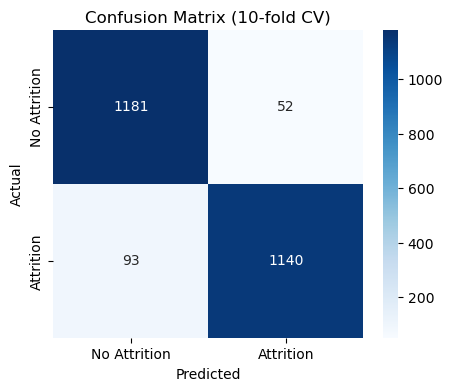

In [26]:
cm = confusion_matrix(y, y_pred_oof)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Attrition", "Attrition"],
            yticklabels=["No Attrition", "Attrition"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (10-fold CV)")
plt.show()

In [27]:
print("Classification Report (10-fold CV):\n")
print(classification_report(y, y_pred_oof, target_names=["No Attrition", "Attrition"]))

Classification Report (10-fold CV):

              precision    recall  f1-score   support

No Attrition       0.93      0.96      0.94      1233
   Attrition       0.96      0.92      0.94      1233

    accuracy                           0.94      2466
   macro avg       0.94      0.94      0.94      2466
weighted avg       0.94      0.94      0.94      2466



ROC-AUC (10-fold CV): 0.9850


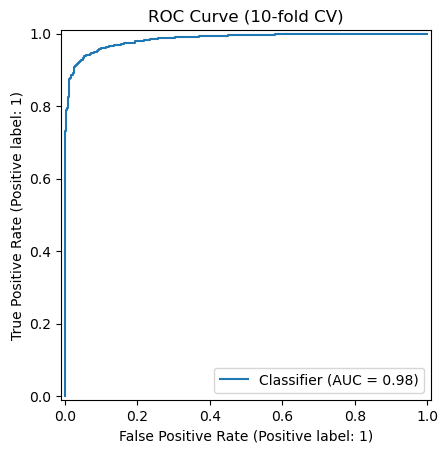

In [30]:
auc = roc_auc_score(y, y_proba_oof)
print(f"ROC-AUC (10-fold CV): {auc:.4f}")

RocCurveDisplay.from_predictions(y, y_proba_oof)
plt.title("ROC Curve (10-fold CV)")
plt.show()

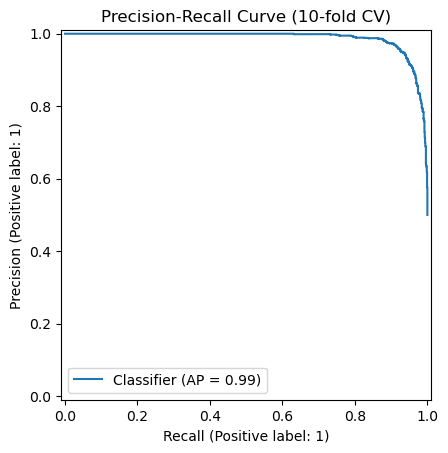

In [32]:
PrecisionRecallDisplay.from_predictions(y, y_proba_oof)
plt.title("Precision-Recall Curve (10-fold CV)")
plt.show()

In [ ]:
joblib.dump(stacking_model, "D:/Machine Learning Projects/2. Employee_Attrition_Prediction/stacking_attrition_model.pkl")

### Model Deployment

In [ ]:

import os
import joblib
import numpy as np
import pandas as pd
from flask import Flask, request, jsonify, render_template
from pyngrok import ngrok
from scipy.special import expit

# -------------------------
# Load saved artifacts
# -------------------------
ENCODER_PATH = "D:/Machine Learning Projects/2. Employee_Attrition_Prediction/onehot_encoder.pkl"
SCALER_PATH  = "D:/Machine Learning Projects/2. Employee_Attrition_Prediction/minmax_scaler.pkl"
MODEL_PATH   = "D:/Machine Learning Projects/2. Employee_Attrition_Prediction/stacking_attrition_model.pkl"

encoder = joblib.load(ENCODER_PATH)  # OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler  = joblib.load(SCALER_PATH)   # MinMaxScaler fitted on df_encoded[non_binary_numeric]
model   = joblib.load(MODEL_PATH)    # Trained on full df_encoded (numeric + OHE), scaled for some cols

# -------------------------
# Raw feature schema (user inputs)
# -------------------------
CATEGORICAL_FEATURES = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]

# These are the numeric columns present in the original raw df (excluding Over18, target),
# that you want the user to input
NUMERIC_FEATURES = [
    "Age",
    "DailyRate",
    "DistanceFromHome",
    "Education",
    "EnvironmentSatisfaction",
    "HourlyRate",
    "JobInvolvement",
    "JobLevel",
    "JobSatisfaction",
    "MonthlyIncome",
    "MonthlyRate",
    "NumCompaniesWorked",
    "PercentSalaryHike",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "TotalWorkingYears",
    "TrainingTimesLastYear",
    "WorkLifeBalance",
    "YearsAtCompany",
    "YearsInCurrentRole",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager",
]

# Constants / dummy columns present in training (we do NOT ask user for these)
EXTRA_FEATURES = ["EmployeeCount", "EmployeeNumber", "StandardHours"]

RAW_ORDER = NUMERIC_FEATURES + EXTRA_FEATURES  # numeric in front (like your df_encoded order before OHE)
# (We will append OHE columns after these.)

# Value lists for select inputs (consistent with IBM HR dataset)
DOMAIN = {
    "BusinessTravel": ["Non-Travel", "Travel_Rarely", "Travel_Frequently"],
    "Department": ["Sales", "Research & Development", "Human Resources"],
    "EducationField": ["Life Sciences", "Medical", "Marketing", "Technical Degree", "Other", "Human Resources"],
    "Gender": ["Male", "Female"],
    "JobRole": [
        "Sales Executive",
        "Research Scientist",
        "Laboratory Technician",
        "Manufacturing Director",
        "Healthcare Representative",
        "Manager",
        "Sales Representative",
        "Research Director",
        "Human Resources",
    ],
    "MaritalStatus": ["Single", "Married", "Divorced"],
    "OverTime": ["Yes", "No"],
}

# -------------------------
# Flask app
# -------------------------
app = Flask(
    __name__,
    template_folder="D:/Machine Learning Projects/2. Employee_Attrition_Prediction/templates",
    static_folder="static"
)

@app.route("/")
def index():
    return render_template(
        "index.html",
        domain=DOMAIN,
        categorical_features=CATEGORICAL_FEATURES,
        numeric_features=NUMERIC_FEATURES
    )

def build_encoded_row(payload: dict) -> pd.DataFrame:
    """
    1) Construct df_raw with user-provided categorical + numeric + extra constants
    2) One-hot encode categoricals with the saved encoder
    3) Concatenate raw numeric (incl extras) + OHE
    4) Apply MinMaxScaler ONLY on the features it was trained on (scaler.feature_names_in_)
    5) Return a single-row DataFrame X aligned in the order [numeric + extras] + OHE columns,
       and if model.feature_names_in_ exists, align to it.
    """
    # Build single-row raw DataFrame
    data = {}
    # Categorical
    for c in CATEGORICAL_FEATURES:
        if c not in payload:
            raise ValueError(f"Missing field: {c}")
        data[c] = str(payload[c]).strip()

    # Numeric
    for n in NUMERIC_FEATURES:
        if n not in payload:
            raise ValueError(f"Missing field: {n}")
        try:
            data[n] = float(payload[n])
        except Exception:
            raise ValueError(f"Invalid numeric value for {n}: {payload[n]}")

    # Constants (from your dataset)
    # Over18 dropped.
    data["EmployeeCount"]  = 1.0
    data["EmployeeNumber"] = 0.0    # can be any dummy; model ignores identity meaning
    data["StandardHours"]  = 80.0

    # Create raw df (single row)
    df_raw = pd.DataFrame([data])

    # ---- OHE ----
    # Use the same encoder; transform only the categorical slice
    X_cat = encoder.transform(df_raw[CATEGORICAL_FEATURES])
    # Dense
    if hasattr(X_cat, "toarray"):
        X_cat = X_cat.toarray()

    # OHE col names
    try:
        ohe_cols = list(encoder.get_feature_names_out(CATEGORICAL_FEATURES))
    except TypeError:
        # older sklearn signature
        ohe_cols = list(encoder.get_feature_names_out())

    df_ohe = pd.DataFrame(X_cat, columns=ohe_cols, index=df_raw.index)

    # Numeric block (user-provided + extras)
    df_num = df_raw[RAW_ORDER].copy()

    # Concatenate numeric + OHE (this matches how your df_encoded is structured)
    df_encoded = pd.concat([df_num, df_ohe], axis=1)

    # ---- Scale only the columns scaler was fit on ----
    # scaler was fitted on df_encoded[non_binary_numeric], where
    # non_binary_numeric were numeric dtype cols with nunique > 2.
    # Because you fit with a DataFrame, we can exploit `feature_names_in_`.
    if hasattr(scaler, "feature_names_in_"):
        scale_cols = list(scaler.feature_names_in_)
    else:
        # Safety fallback—if scaler doesn't expose names, *do not* attempt to transform everything.
        # In that case you should re-save your scaler fitted on a DataFrame so names are present.
        raise RuntimeError("Scaler does not expose feature_names_in_. Please fit scaler with a DataFrame.")

    # Ensure all expected scale columns exist in the current encoded row
    missing = [c for c in scale_cols if c not in df_encoded.columns]
    if missing:
        raise RuntimeError(f"Missing columns required by scaler: {missing}")

    # Apply scaling in place
    df_encoded.loc[:, scale_cols] = scaler.transform(df_encoded[scale_cols])

    # ---- Align to model expected columns if available ----
    if hasattr(model, "feature_names_in_"):
        # For sklearn 1.0+, many models keep the fitted feature names
        model_cols = list(model.feature_names_in_)
        # Add any missing columns with 0
        for c in model_cols:
            if c not in df_encoded.columns:
                df_encoded[c] = 0.0
        # Drop extras not used by model
        df_encoded = df_encoded[model_cols]
    else:
        # Otherwise, use current "numeric + extras + OHE" order; the model must have been trained on same order.
        pass

    return df_encoded

@app.route("/predict", methods=["POST"])
def predict():
    try:
        payload = request.get_json() if request.is_json else {k: v for k, v in request.form.items()}
        X = build_encoded_row(payload)

        # Predict probability for attrition=Yes
        if hasattr(model, "predict_proba"):
            proba = float(model.predict_proba(X)[0, 1])
        elif hasattr(model, "decision_function"):
            proba = float(expit(model.decision_function(X))[0])
        else:
            return jsonify({"error": "Model lacks predict_proba/decision_function"}), 500

        label = "High Attrition Risk" if proba >= 0.5 else "Low Attrition Risk"
        return jsonify({
            "label": label,
            "probability": round(proba, 4),
            "prob_yes": round(proba, 4),
            "prob_no": round(1.0 - proba, 4)
        })
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == "__main__":
    # -------------------------
    # ngrok tunnel
    # -------------------------
    NGROK_TOKEN = os.getenv("NGROK_AUTHTOKEN", "TOKEN")
    if NGROK_TOKEN and NGROK_TOKEN != "TOKEN":
        ngrok.set_auth_token(NGROK_TOKEN)
        public_url = ngrok.connect(5000, "http")
        print(f"[ngrok] Public URL → {public_url}")
    else:
        print("[ngrok] Skipping; set NGROK_AUTHTOKEN to expose publicly.")

    app.run(host="0.0.0.0", port=5000, debug=False)


[ngrok] Skipping; set NGROK_AUTHTOKEN to expose publicly.
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.100.28:5000
Press CTRL+C to quit
192.168.100.28 - - [30/Aug/2025 01:00:10] "GET / HTTP/1.1" 200 -
192.168.100.28 - - [30/Aug/2025 01:01:59] "POST /predict HTTP/1.1" 200 -
192.168.100.28 - - [30/Aug/2025 01:02:30] "POST /predict HTTP/1.1" 200 -
